# Google Earth Engine Tutorial

Code walkthrough from introductory tutorial at: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api


In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Enter verification code:  4/1AdQt8qj8QpDtvA3qlKnWVZi5CAd65o8jMmBeC6DG-bjx7JlL_Vw79YwU__s



Successfully saved authorization token.


In [2]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')


In [3]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)


In [4]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)


In [5]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)


Ground elevation at urban point: 196 m
Average daytime LST at urban point: 23.12 °C
Land cover value at urban point is: 13


In [6]:
# Print the elevation near Lyon, France.
elv_rural_point = elv.sample(r_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at rural point:', elv_rural_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_rural_point = lst.mean().sample(r_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at rural point:', round(lst_rural_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_rural_point = lc.first().sample(r_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at rural point is:', lc_rural_point)


Ground elevation at rural point: 385 m
Average daytime LST at rural point: 21.92 °C
Land cover value at rural point is: 12


In [7]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]


[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 4.810478346460038, 45.77365530231022, 1483228800000, None, 2],
 ['2017_01_02', 4.810478346460038, 45.77365530231022, 1483315200000, None, 2],
 ['2017_01_03', 4.810478346460038, 45.77365530231022, 1483401600000, None, 2],
 ['2017_01_04',
  4.810478346460038,
  45.77365530231022,
  1483488000000,
  13808,
  17]]

In [8]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time', 'datetime',  *list_of_bands]]

    return df


In [10]:
lst_df_urban = ee_array_to_df(lst_u_poi, ['LST_Day_1km'])


def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius


# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()


,time,datetime,LST_Day_1km
3,1483488000000,2017-01-04,3.01
4,1483574400000,2017-01-05,2.39
5,1483660800000,2017-01-06,0.89
6,1483747200000,2017-01-07,-0.11
15,1484524800000,2017-01-16,2.33


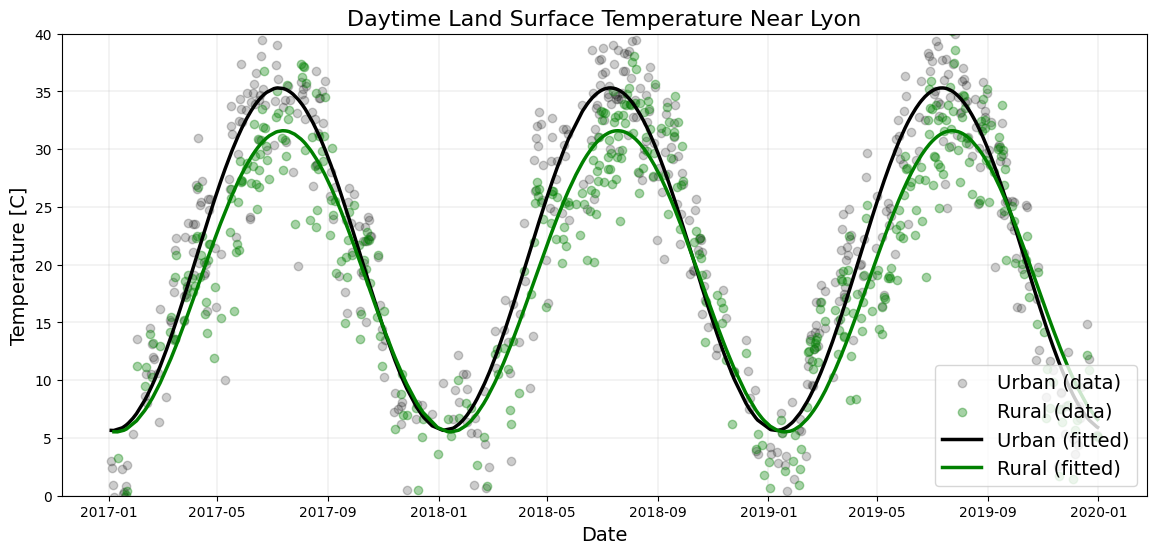

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()


In [12]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)


In [13]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


In [14]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90fe48071c524c816cb939b798c9b18f-77eb6d8fed04c8dd3aab31ebdb1a5528:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [15]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))


In [16]:
# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': lyon, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)


In [17]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# Clip the image by France.
elv_fr = elv_img.clip(france)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in France.
Image(url=url)


In [18]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_lyon_france',
                                     scale=30,
                                     region=lyon,
                                     fileNamePrefix='my_export_lyon',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()


In [19]:
task.status()

{'state': 'COMPLETED',
 'description': 'elevation_near_lyon_france',
 'creation_timestamp_ms': 1662413264812,
 'update_timestamp_ms': 1662413283614,
 'start_timestamp_ms': 1662413270480,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 0.6176568269729614,
 'id': '7KKKGG35QS5GXX7F7LKSYAS2',
 'name': 'projects/earthengine-legacy/operations/7KKKGG35QS5GXX7F7LKSYAS2'}

In [20]:
link = lst_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': lyon})
print(link)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24ee5637c5ffc84fcd0a16125c808536-58ade2969c733fbb147d3efa42862627:getPixels


In [21]:
import folium

# Define the center of our map.
lat, lon = 45.77, 4.855

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map


In [22]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


In [23]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


In [24]:
my_map.save('my_lc_interactive_map.html')


In [25]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map
